<h1> Quora Question Pairs </h1>

<h1> Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("train.csv")
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df=df.head(100000)

In [4]:
df.describe()

,id,qid1,qid2,is_duplicate
count,100000.000000,100000.00000,100000.000000,100000.000000
mean,49999.500000,76207.29047,76204.708200,0.372540
std,28867.657797,48355.48207,48454.311214,0.483483
min,0.000000,1.00000,2.000000,0.000000
25%,24999.750000,33292.00000,32946.750000,0.000000
50%,49999.500000,72895.00000,72756.000000,0.000000
75%,74999.250000,117412.50000,117562.750000,1.000000
max,99999.000000,165930.00000,165931.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     100000 non-null  object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


<h3>Distribution of data points among output classes</h3>


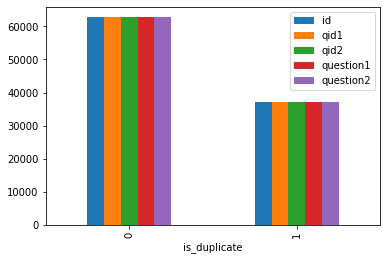

In [6]:
df.groupby("is_duplicate").count().plot.bar()

<h3> Checking for Duplicates </h3>

In [7]:
#checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3>Checking for NULL values </h3>

In [8]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows["id"])

Series([], Name: id, dtype: int64)


<h2>  Feature Extraction </h2>

Let us now construct a few features like:
 - q1_wordslen= Number of words in Question 1
 - q2_wordslen= Number of words in Question 2
 - common_words = (Number of common unique words in Question 1 and Question 2)
 - Total_words_union=(Total num of words in Question 1 + Total num of words in Question 2)-common_words
 



In [9]:
q1=list()
for i in range(len(df)) : 
     q1.append(df.loc[i, "question1"].split())## here q1 is list of questions from df["question1"] 
q2=list()
for i in range(len(df)):
     q2.append(df.loc[i,"question2"].split())## here q2 is list of questions from df["question2"] 


In [10]:
print(q1[0])
print(q2[0])
print(len(set(q1[i])&set(q2[i])))
q1_word_len=list()
q2_word_len=list()
common_words=list()
total_words=list()
print(len(df))
t=list()
for i in range(len(df)):
    q1_word_len.append(len(q1[i]))
    q2_word_len.append(len(q2[i]))
    
for i in range(len(df)):
    common_words.append(len(set(q1[i])&set(q2[i])))
    total_words.append(len(q1[i])+len(q2[i])-len(set(q1[i])&set(q2[i])))
r=list(zip(q1_word_len,q2_word_len,common_words,total_words))
print(r)

['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india?']
['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market?']
1
100000
[(14, 12, 10, 16), (8, 13, 4, 17), (14, 10, 3, 21), (11, 9, 0, 20), (13, 7, 2, 18), (16, 16, 7, 25), (4, 11, 0, 15), (7, 9, 4, 12), (8, 8, 6, 10), (9, 9, 3, 15), (9, 19, 1, 27), (9, 8, 4, 13), (7, 8, 5, 10), (7, 6, 5, 8), (29, 29, 19, 39), (15, 17, 4, 28), (4, 4, 3, 5), (12, 8, 1, 19), (14, 13, 5, 22), (9, 9, 7, 11), (5, 7, 3, 9), (6, 10, 1, 15), (9, 7, 4, 12), (7, 11, 0, 18), (17, 10, 0, 27), (14, 15, 13, 16), (4, 6, 3, 7), (8, 7, 0, 15), (8, 9, 7, 10), (8, 12, 6, 14), (9, 8, 6, 11), (16, 11, 3, 24), (14, 15, 11, 18), (17, 9, 1, 25), (8, 6, 5, 9), (13, 14, 4, 23), (23, 18, 9, 32), (25, 37, 4, 58), (6, 7, 4, 9), (15, 12, 1, 26), (4, 6, 0, 10), (8, 7, 7, 8), (9, 9, 8, 10), (16, 7, 4, 19), (14, 15, 12, 17), (9, 9, 3, 15), (11, 9, 0, 20), (24, 12, 3, 33), (13, 10, 8, 15), (5, 5,

In [11]:
data=pd.DataFrame(r,columns=["q1_wordlen","q2_wordlen","common_wordslen","total_words_union"])
data
df["q1_wordlen"]=data["q1_wordlen"]
df["q2_wordlen"]=data["q2_wordlen"]
df["common_words"]=data["common_wordslen"]
df["total_words_union"]=data["total_words_union"]
df


,id,qid1,qid2,question1,question2,is_duplicate,q1_wordlen,q2_wordlen,common_words,total_words_union
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,10,16
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8,13,4,17
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14,10,3,21
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11,9,0,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13,7,2,18
...,...,...,...,...,...,...,...,...,...,...
99995,99995,165922,165923,What are some of the most iconic images of foo...,What are some of the most iconic images of women?,0,10,10,8,12
99996,99996,165924,165925,How green is green tea?,"Why isn't ""green"" tea green?",0,5,5,0,10
99997,99997,165926,165927,Who would win: Black Panther or Batman?,Who would win in a fight between Black Panther...,1,7,11,5,13
99998,99998,165928,165929,"Which school is better, for what, and why: Par...",What are some good design schools/colleges on ...,0,11,10,1,20


In [12]:
## code from https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

sw = stopwords.words('english')## removing the stop words in q1 and q2

similarity=list()

for i in range(len(df)):
    X_set = {w for w in q1[i] if not w in sw}  
    Y_set = {w for w in q2[i] if not w in sw}
    
    l1 =[];l2 =[] 
    
    rvector = X_set.union(Y_set)  
    for w in rvector: 
            if w in X_set: l1.append(1) # create a vector of the texts 
            else: l1.append(0) 
            if w in Y_set: l2.append(1) 
            else: l2.append(0) 
    c = 0
  
    # cosine formula to find similarity  
    for i in range(len(rvector)): 
            c+= l1[i]*l2[i] 
            similarity.append(c / (float((sum(l1)*sum(l2))**0.5)))

In [13]:
similarity[2]

0.3086066999241838

In [14]:
data=pd.DataFrame(similarity,columns=["similarity"])
df["similarity"]=data["similarity"]
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_wordlen,q2_wordlen,common_words,total_words_union,similarity
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,10,16,0.000000
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8,13,4,17,0.154303
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14,10,3,21,0.308607
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11,9,0,20,0.308607
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13,7,2,18,0.462910


<h3>Analysis of some of the extracted features </h3>

<h4>Feature: total_word_union </h4>

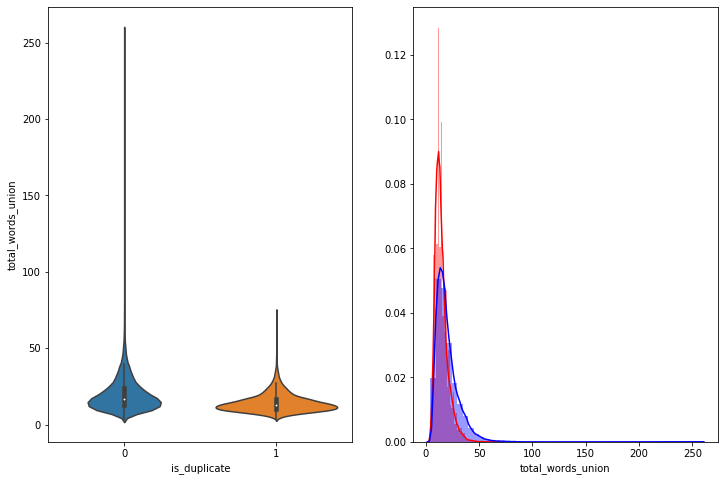

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'total_words_union', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['total_words_union'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['total_words_union'] , label = "0" , color = 'blue' )
plt.show()

The overlap of total words Union in q1 and q2 of both 1 and 0 is very high 

<h4>Feature: common_words </h4>

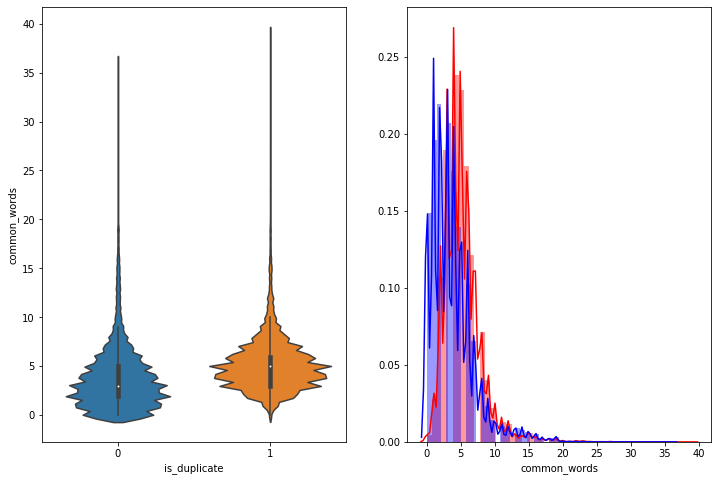

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_words', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['common_words'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_words'] , label = "0" , color = 'blue' )
plt.show()

The overlap of common words in q1 and q2 of both 1 and 0 is very high 

<h4>Feature: q1_wordlen </h4>

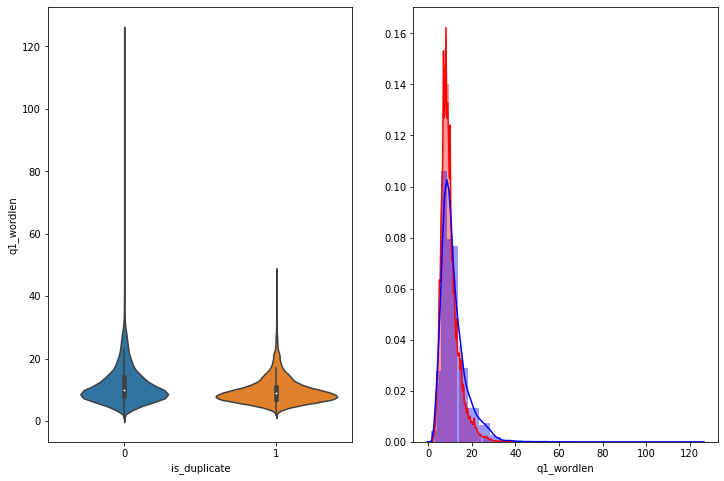

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'q1_wordlen', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q1_wordlen'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q1_wordlen'] , label = "0" , color = 'blue' )
plt.show()

<h4>Feature: q2_wordlen </h4>

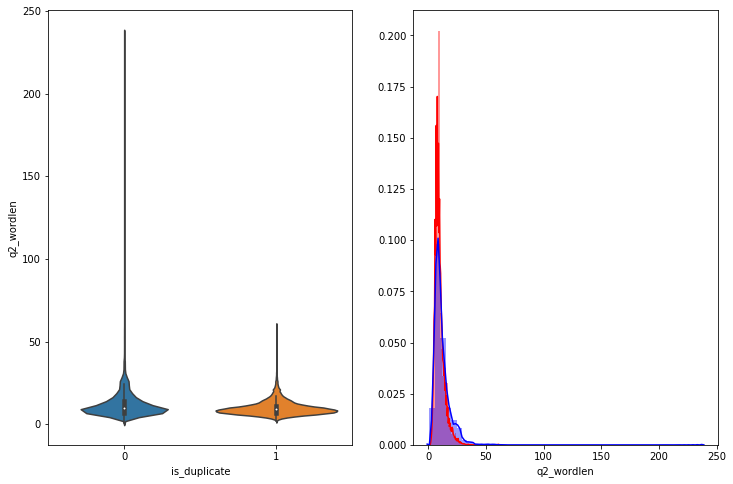

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'q2_wordlen', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q2_wordlen'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q2_wordlen'] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
For both q1_wordlen and q2_wordlen the overlap is  

In [17]:
df.to_csv("xtrain.csv")